# GLM with PyMC3
Hand coded, not using the GLM module.

In [37]:
import pymc3 as pm
import arviz as az
import numpy as np
import pandas as pd
import patsy

%config InlineBackend.figure_format = 'retina'

In [38]:
SEED = 12345

sample_options = {
    "tune": 4000,
    "draws": 2000,
    "chains": 4,
    "cores": 2,
    "nuts_kwargs": {"target_accept": 0.95},
    "random_seed": SEED,
}

## GLM code

In [39]:
def glm(formula, data):
    """Build PyMC3 GLM and run parameter estimation.
    Return model and trace."""
    
    # calculate design matrix
    y_obs, X = patsy.dmatrices(formula, data)
    # convert to arrays
    y_obs, X = np.asarray(y_obs), np.asarray(X)
    nβ = X.shape[1]

    # Build model
    with pm.Model() as model:
        # Priors
        # Note β must be a column vector
        β = pm.Normal("β", mu=0, sd=10, shape=(nβ,1))
        sd = pm.HalfNormal("sd", sd=2)

        # Likelihood
        y = pm.Normal("y", mu=pm.math.dot(X,β) , sd=sd, observed=y_obs)
        
        # Sample
        trace = pm.sample(**sample_options)
        
    return model, trace

## Difference between 2 groups

In [40]:
data = pd.DataFrame(
    {"y": [1, 2, 1.5, 2.1, 5.3, 6.4, 5.8, 4.3], "group": ["a", "a", "a", "a", "b", "b", "b", "b"]}
)
data

,y,group
0,1.0,a
1,2.0,a
2,1.5,a
3,2.1,a
4,5.3,b
5,6.4,b
6,5.8,b
7,4.3,b


In [41]:
model, trace = glm("y ~ group", data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sd, β]
Sampling 4 chains, 0 divergences: 100%|██████████| 24000/24000 [00:11<00:00, 2060.80draws/s]


Visualise model

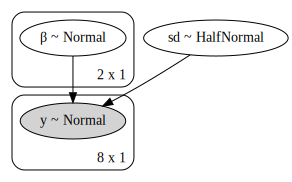

In [42]:
pm.model_to_graphviz(model)

Visualise results

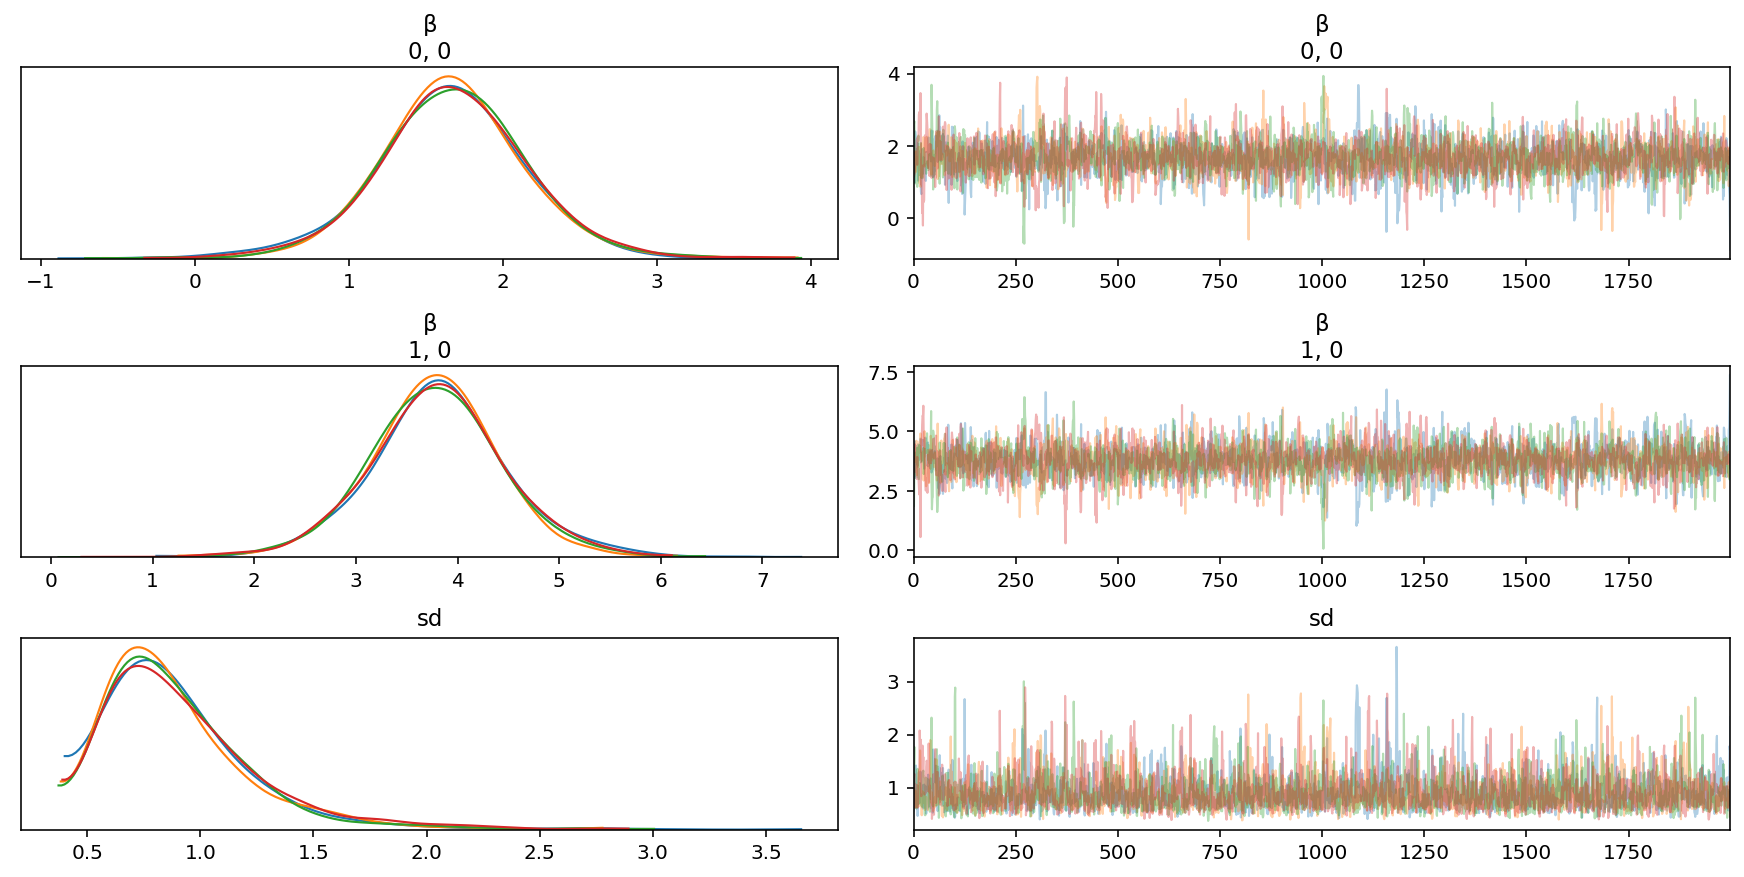

In [43]:
az.plot_trace(trace);

## Linear regression
Now we use the same GLM model with a continuous predictor rather than a categorical predictor.

In [51]:
x = np.array([1, 2, 3, 4, 5, 6, 7, 8])
data = pd.DataFrame({"y": np.random.normal(loc=x, scale=0.5, size=len(x)),
                     "x": x})
data

,y,x
0,0.831048,1
1,2.052786,2
2,3.139610,3
3,3.970743,4
4,4.848260,5
5,5.398932,6
6,7.235785,7
7,8.004493,8


In [52]:
model, trace = glm("y ~ x", data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sd, β]
Sampling 4 chains, 0 divergences: 100%|██████████| 24000/24000 [00:15<00:00, 1507.92draws/s]
The number of effective samples is smaller than 25% for some parameters.


Visualise model

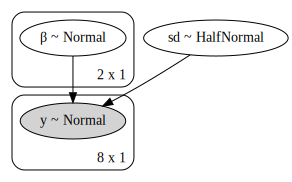

In [53]:
pm.model_to_graphviz(model)

Visualise results

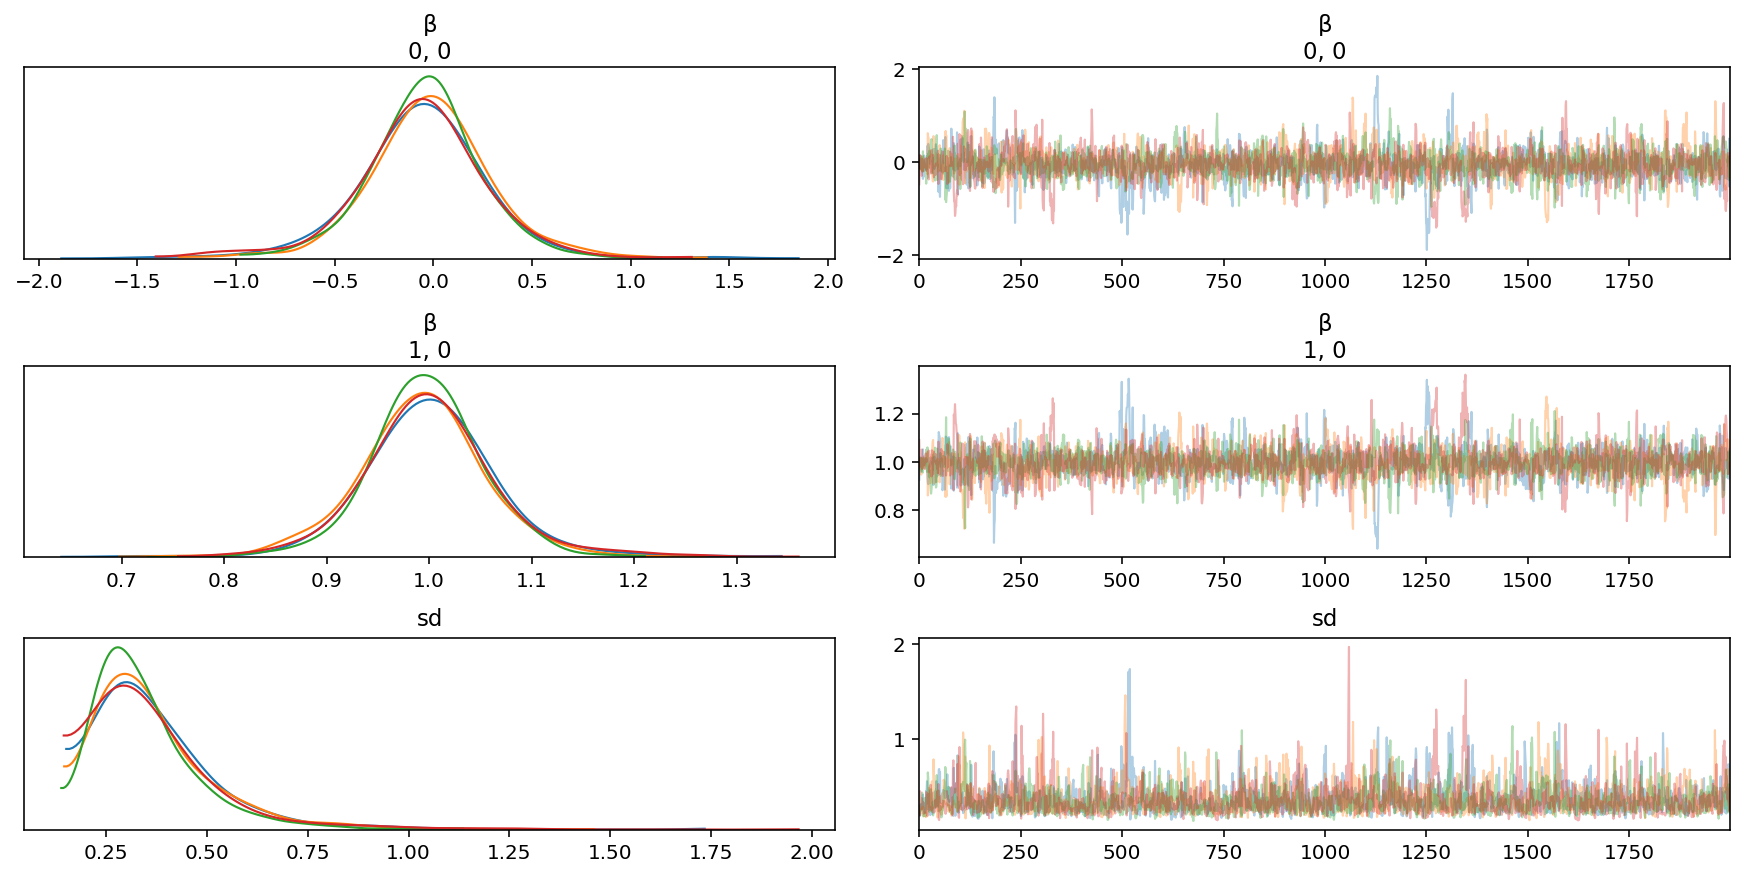

In [54]:
az.plot_trace(trace);

In [55]:
trace.varnames

['β', 'sd_log__', 'sd']

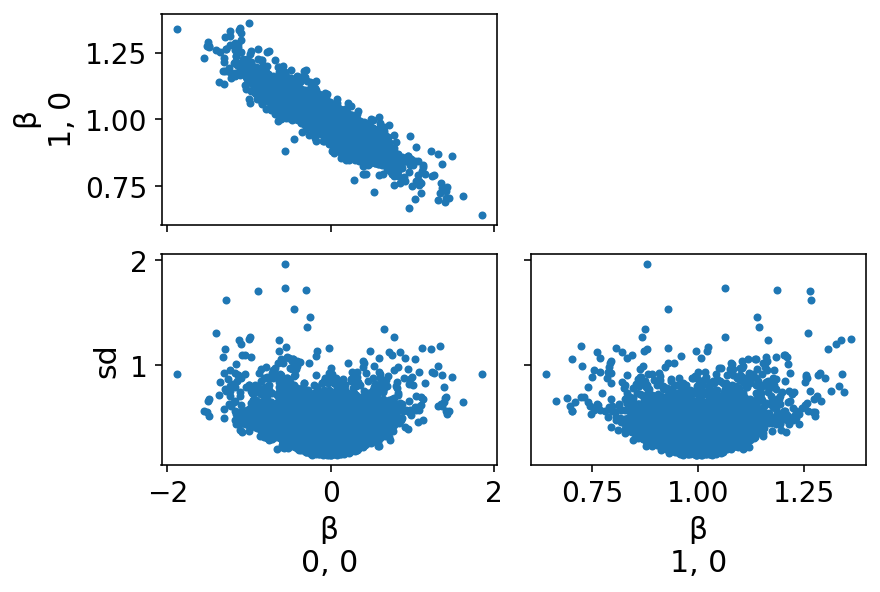

In [56]:
ax = az.plot_pair(
    trace,
    var_names=["β", "sd"],
    kind="scatter",
    divergences=True
)